# <span style="color:#0b486b"> Data Visualisation </span>

In [1]:
# import the necessary files
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pymongo import MongoClient
from time import sleep
from IPython.display import display, clear_output
import time
import folium

# Connect to MongoDB
host_ip = "192.168.0.116"
client = MongoClient(host_ip, 27017)
db = client.fit3182_a2_db




<h1> Part 1: Joined Streaming Visualisation Graph </h1>

<h2>Overview</h2>

This section contains a dual-plot graph to visualize the joined streaming data between all the camera events. This dual-plot visualization provides a dynamic, time-series analysis of traffic violations, displaying hourly aggregated violation counts alongside the mean speed of these violations. Its primary purpose is to enable the identification of temporal patterns, trends, and anomalies in speeding behavior, thereby supporting informed decision-making for traffic management and safety interventions.


<h2>Plot Description and Features</h2>

<h3>Plot 1: Violations vs Arrival Time (Top Plot)</h3>

<p><b>Content: </b>Displays the total count if all recorded speeding violations (both instantaneous and average speed violations) aggregated into hourly bins on their timestamp_end.</p>


<p><b><font color='blue'>Key Features and Importance: </font></b></p>

<p><b>Mininum and Maximum Annotations</b></p>
<p>Clearly highlight the hours with the lowest and highest with the current information received. This allows for quick identification of peak and off-peak periods of non-compliance. This is crucial for understanding when violations are most and least common.</p>

<p><b>Average Violations Count Line</b></p>
<p>Provides a baseline across the observed period, helping to contextualize whether current hourly counts are above or below the typical level.</p>

<p><b>Spike and High Difference Shading</b></p>
<p>These visual cues are critical for immediately drawing attention to hours where there's a sudden and significant surge in violations compared to the previous hour. This indicates periods of rapidly deteriorating compliance or unusual traffic events.
    <font color='green'>Green</font> represents a spike in violation in the graph while <font color='red'>Red</font> represents of a drop in violation count
</p>


<h3>Plot 2: Speed vs Arrival Time (Bottom Plot)</h3>

<p><b>Content: </b>Shows the average speed reading of all violations recorded within each corresponding hourly bin.</p>

<p><b><font color='blue'>Key Features and Importance: </font></b></p>



<p><b>Mininum and Maximum Annotations</b></p>
<p>Indicate the hourly bins where the average speed of violators was at its lowest and highest, providing insight into the range  of speeding incidents over time.</p>

<p><b>Average Speed line</b></p>
<p>Illustrates the typical mean speed of violations, offering a benchmark for the general severity of speeding.</p>

<p><b>90th Percentile Speed Line</b></p>
<p>This is a vital indicator of more extreme speeding behavior. It highlights the speed which 90% of the hourly average violation speeds fall below, thus drawing attention to the top 10% of most severe hourly speeding averages. This helps differentiate between generally higher speeds and exceptionally high-risk speeding periods.</p>



    
   


<h2>Connecting Patterns across both plots and discussing implications</h2>


 
<b>High Violation Count and High Violation Speed</b>

If the data shows high violations (plot 1) while high violation speed (plot 2, potentially exceeding the 90th percentile). This could imply significant risk as these events are severe for the safety of road users. This pattern might suggest widespread aggressive driving or conditions where drivers feel emboldened to speed excessively, warranting urgent attention. How


<b>High Violation Count and Moderate/Low Average Violation Speed</b>

A high number of violations (Plot 1) paired with an average violator speed that is only moderately above the limit (Plot 2) could imply widespread, but less severe, non-compliance. The implication here might be less about overtly reckless individuals and more about systemic issues like unclear speed limits, road design encouraging slightly higher speeds, or a general underestimation of speed by many drivers. For example, during the start of rush hour or the end of rush hour, where more vehicles are more eager to speed modestly to "beat the traffic" to get home quicker. However, the presence of other vehicles (even if not yet fully congested) might naturally temper the average speed of those violating from becoming excessively high. There's less opportunity for extreme speeding compared to an empty road.

<b>Low violations and high violation speed</b>


If violation counts are low (Plot 1) but the average speed of these few violators is exceptionally high (Plot 2), this points towards isolated incidents of extreme speeding. The implication is a different risk profile – fewer offenders, but those who offend do so at dangerously high speeds, suggesting a need for targeted enforcement against high-risk individuals. For example, extreme speeding commonly occurs around midnight due to lack of enforcement and low traffic on freeways.


<b>How Spikes and Drops in violation affect</b>

A noticeable drop in violation count (Plot 1) often coincides with a reduction in average speed (Plot 2). This suggests either a temporary absence of incoming vehicles or a general adherence to speed limits during that period. Such trends may reflect low traffic volume, offering valuable insight into traffic behavior and enforcement effectiveness.


These connected patterns allow authorities to move beyond simply counting violations to understanding the nature and potential severity of speeding behaviors at different times. This nuanced understanding has direct implications for tailoring enforcement strategies, public awareness campaigns, and road safety engineering efforts. For example, widespread minor speeding might call for educational campaigns or traffic calming measures, while isolated extreme speeding might necessitate targeted patrols.





<h2>Critical Evaluation for Operational Decisions and Alerts</h2>

The visual cues displayed on the graph allow for support in operational decisions and trigger alerts. 

<h3>Operational Decisions</h3>




<h3>Triggering Alerts</h3>




<h3>Critical Evaluations on whether its visual cues will support operational decisions or trigger alerts</h3>




















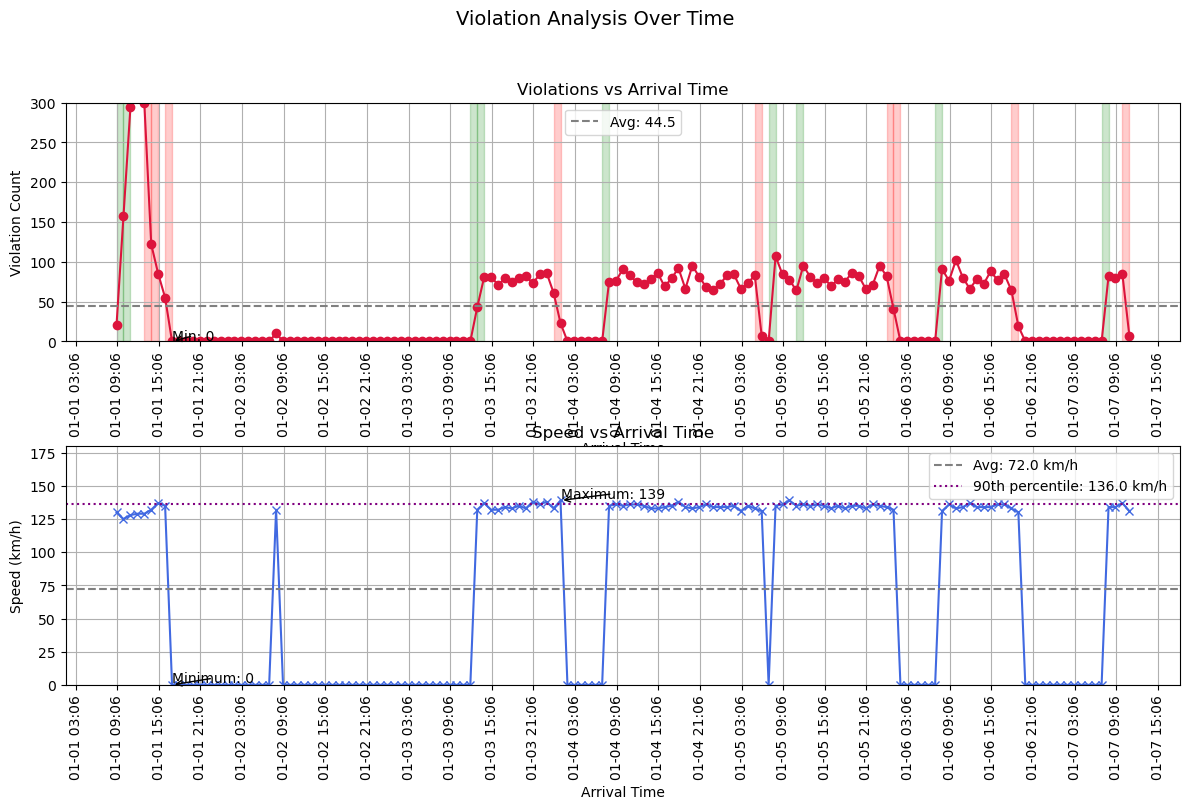

KeyboardInterrupt: 

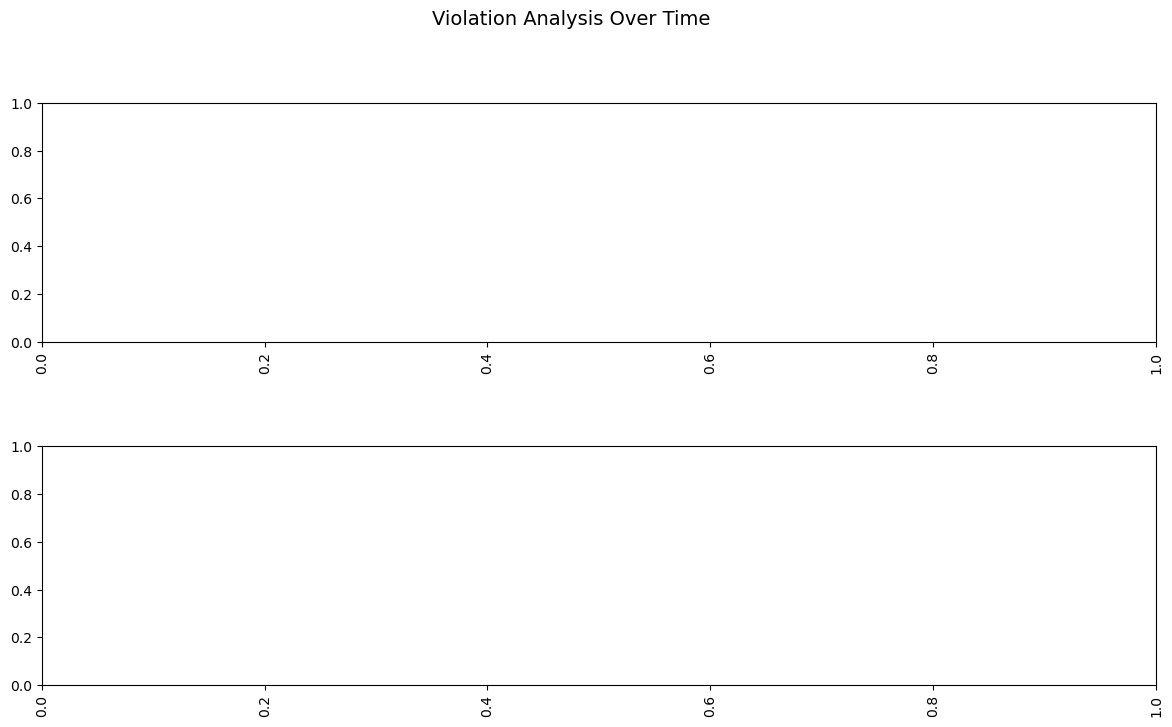

In [5]:
def init_dual_plots(interval_minutes=1):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle("Violation Analysis Over Time", fontsize=14)

    time_formatter = mdates.DateFormatter('%H:%M')
    time_locator = mdates.MinuteLocator(interval=interval_minutes) # configure the ticks between the x axis 

    for ax, ylabel in zip(axs, ["Violation Count", "Speed (km/h)"]):
        ax.set_xlabel("Arrival Time")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.xaxis.set_major_formatter(time_formatter)
        ax.xaxis.set_major_locator(time_locator)
        ax.tick_params(axis='x', rotation=90)

    axs[0].set_title("Violations vs Arrival Time")
    axs[0].set_ylim(0, 300)

    axs[1].set_title("Speed vs Arrival Time")
    axs[1].set_ylim(0, 180)
    plt.subplots_adjust(hspace=1,bottom=0.8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axs

def plot_graph(fig,axs):
    
    axs[0].clear()
    axs[1].clear()
    
    
    violations_db = db.violations

    # Load data from MongoDB into a DataFrame
    violations_pd = pd.DataFrame(list(violations_db.find()))

    if violations_pd.empty:
        print("No data found in violations collection.")
        return

    # Convert timestamp to datetime
    violations_pd['timestamp_end'] = pd.to_datetime(violations_pd['timestamp_end'])
    violations_pd['time_bin'] = violations_pd['timestamp_end'].dt.floor('1H') # round down the nearest min
    
    
    # Group by the bins specified
    grouped = violations_pd.groupby('time_bin').agg({
        'speed_reading': 'mean', # get the mean
        'timestamp_end': 'count' # get the all the timstamps which fall under the same time_bin and that would be the number of violations in the time_bin
    }).rename(columns={'timestamp_end': 'violation_count'})


    if grouped.empty:
        print("No data available after grouping.")
        return
    
    
### APPLY FILTER COMMENT OUT IF NOT NEEDED
#     # Define time range (modify these as needed)
#     start_filter = pd.to_datetime("2024-01-01 13:00:00")
#     end_filter = pd.to_datetime("2024-01-01 15:00:00")

#     # Apply filter to the grouped DataFrame
#     grouped = grouped.loc[(grouped.index >= start_filter) & (grouped.index <= end_filter)]
    

    # transform timestamps which have no violation count
    if not grouped.empty:
        # create a complete sequence of hourly timestamps that spans the entire period covered by your existing grouped data.
        full_time_range = pd.date_range(start=grouped.index.min(), end=grouped.index.max(), freq='H')
        # ensure that every hour within the full time range has a row even with hours which have no violation count
        grouped = grouped.reindex(full_time_range)
        # insert 0 with null values of the violation_count column on newly created rows
        grouped['violation_count'] = grouped['violation_count'].fillna(0).astype(int)
        grouped['speed_reading'] = grouped['speed_reading'].fillna(0).astype(int)
        

    # Calculate dynamic interval for x-axis locator
    start_time = grouped.index.min()
    end_time = grouped.index.max()
    total_hours = (end_time - start_time).total_seconds() / 3600.0 # Since bins are hourly

    dynamic_locator_interval_minutes = 60 # Default to hourly ticks
    if total_hours <= 0:
        dynamic_locator_interval_minutes = 60 
    elif total_hours <= 6: # Up to 6 hours, tick every hour
        dynamic_locator_interval_minutes = 60
    elif total_hours <= 12: # Up to 12 hours, tick every 2 hours
        dynamic_locator_interval_minutes = 120
    elif total_hours <= 24: # Up to 24 hours, tick every 4 hours
        dynamic_locator_interval_minutes = 240
    else: # More than 24 hours, tick every 6 hours
        dynamic_locator_interval_minutes = 360
        
    print(dynamic_locator_interval_minutes)

    # Re-apply formatting to axes
    time_formatter = mdates.DateFormatter('%m-%d %H:%M')
    time_locator = mdates.MinuteLocator(interval=dynamic_locator_interval_minutes)

    for ax, ylabel in zip(axs, ["Violation Count", "Speed (km/h)"]):
        ax.set_xlabel("Arrival Time")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.xaxis.set_major_formatter(time_formatter)
        ax.xaxis.set_major_locator(time_locator)
        ax.tick_params(axis='x', rotation=90)

    axs[0].set_title("Violations vs Arrival Time")
    axs[0].set_ylim(0, 300) # User defined limit

    axs[1].set_title("Speed vs Arrival Time")
    axs[1].set_ylim(0, 180) # User defined limit


    # Plot data
    axs[0].plot(grouped.index, grouped['violation_count'], marker='o', color='crimson')# Plotting the grouped time intervals on the x-axis and the number of violations per interval on the y-axis
    axs[1].plot(grouped.index, grouped['speed_reading'], marker='x', color='royalblue')

    # Annotate max violation count
    max_violation_time = grouped['violation_count'].idxmax()
    max_violation_value = grouped['violation_count'].max()
    axs[0].annotate(f'Max: {max_violation_value}',
                    xy=(max_violation_time, max_violation_value),
                    xytext=(max_violation_time, max_violation_value + 2),
                    arrowprops=dict(facecolor='red', arrowstyle='->'))
    
    # Annotate the min violation count
    min_violation_time = grouped['violation_count'].idxmin()
    min_violation_value = grouped['violation_count'].min()
    axs[0].annotate(f'Min: {min_violation_value}',
                    xy=(min_violation_time, min_violation_value),
                    xytext=(min_violation_time, min_violation_value + 2),
                    arrowprops=dict(facecolor='red', arrowstyle='->'))
    
    # Annotate the average violation count over the entire period so far
    avg_violations = grouped['violation_count'].mean()
    axs[0].axhline(avg_violations, color='gray', linestyle='--', label=f'Avg: {avg_violations:.1f}')
    
    axs[0].legend()
    
    
    
    # Annotate lowest speed violation
    min_speed_time = grouped['speed_reading'].idxmin() # get the lowest time
    min_speed_value = grouped['speed_reading'].min() # get the lowest value
    axs[1].annotate(f'Minimum: {int(min_speed_value)}',
                    xy=(min_speed_time, min_speed_value),
                    xytext=(min_speed_time, min_speed_value + 2),
                    arrowprops=dict(facecolor='purple', arrowstyle='->'))
    
    
    # Annotate the highest speed violation
    max_speed_time = grouped['speed_reading'].idxmax() # get the lowest time
    max_speed_value = grouped['speed_reading'].max() # get the lowest value
    axs[1].annotate(f'Maximum: {int(max_speed_value)}',
                    xy=(max_speed_time, max_speed_value),
                    xytext=(max_speed_time, max_speed_value + 2),
                    arrowprops=dict(facecolor='purple', arrowstyle='->'))
    
    
    # find drops or spikes
    grouped['violation_diff'] = grouped['violation_count'].diff() # find the difference between consecutive rows of violation_count column
    
    
    # Shaded region for drops
    drops = grouped[grouped['violation_diff'] < -30] 
    for time_bin_val in drops.index:
        if isinstance(time_bin_val, pd.Timestamp):
            axs[0].axvspan(time_bin_val, time_bin_val - pd.Timedelta(hours=1), color='red', alpha=0.2, label='_nolegend_')
        
    # Shaded region for spikes
    spikes = grouped[grouped['violation_diff'] > 30] # when there is a drop in violation
    for time_bin_val in spikes.index:
        if isinstance(time_bin_val, pd.Timestamp):
            axs[0].axvspan(time_bin_val, time_bin_val - pd.Timedelta(hours=1), color='green', alpha=0.2)
    
    

    # Draw average speed line
    avg_speed = grouped['speed_reading'].mean()
    axs[1].axhline(avg_speed, color='gray', linestyle='--', label=f'Avg: {avg_speed:.1f} km/h')
    
    
    # Draw the 90th percentile
    percentile_90 = grouped["speed_reading"].quantile(0.9)
    axs[1].axhline(percentile_90, color='purple', linestyle=':', label=f'90th percentile: {percentile_90:.1f} km/h')
    axs[1].legend()
    


# initialise only once

fig, axs = init_dual_plots(interval_minutes=200)
# plot_graph(fig,axs)
while True:  
    plot_graph(fig,axs)
    clear_output(wait = True)
    display(fig)
    time.sleep(5)

# with db.watch() as stream:
#     print("Watching for changes...")
#     for change in stream:
#         pprint.pprint(change)
    


    


<h1>Part 2: Map Visualisation</h1>

<h2>Overview</h2>

This map-based visualization complements the dual-plot time-series graph by representing the spatial dimension of the joined streaming traffic violation data. By integrating camera location metadata with both instantaneous and average speed violation events, this map allows users to identify geographic hotspots, movement patterns, and temporal progression of people not complying with the speed limit.The map supports interactive analysis with real-time animated markers and polylines, facilitating operational traffic management and strategic enforcement planning.


<h2>Map Description and Features</h2>

<h3>Instantaneous Violations (Circle Markers)</h3>

<p><b>Content: </b>Each camera is represented by a dynamic marker that reflects the count of instantaneous speed violations aggregated in hourly time bins.</p>


<p><b><font color='blue'>Key Features and Importance: </font></b></p>

<p><b>Color coded Markers based on Violation Count</b></p>
<p>The color transitions from blue(low) to orange and red(high) to emphasize hotspots. This enables a <b>heatmap</b> view to visually recognise of areas with significant non-compliance easily</p>

<p><b>Animated Marker Playback Over Time:</b></p>

<p>Using TimestampedGeoJson, the markers change dynamically as the timeline progresses. This allows observers to detect patterns in violation surges across different times of day — e.g., morning rush hours or late-night speeding.</p>


<p><b>Popup with Camera ID and Violation Count:</b></p>

<p>Each marker provides detailed stats per time bin, supporting micro-level analysis and comparison between cameras.</p>


<h3>Average Speed Violations (Polylines)</h3>

<font color='blue'>Key Features and Importance:</font>

<p><b>Dynamic Connections Between Cameras:</b></p>

The use of LineString geometries visualizes the movement trajectory of vehicles between checkpoints. The line width increases proportionally with the number of violations, drawing attention to frequently abused road segments.

<p><b>Playback Synchronization with Time:</b></p>

Polylines appear on the map in sync with the same hourly bins as the circle markers, enabling temporal correlation across space.

<p><b>Informative Tooltips:</b></p>

On hover, each line displays the camera IDs and count of average violations, enabling context-aware exploration of violation paths.




































In [6]:
import folium
from folium.plugins import TimestampedGeoJson
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
import json

# Connect to MongoDB
host_ip = "192.168.0.116"
client = MongoClient(host_ip, 27017)
db = client.fit3182_a2_db

# Load camera data
cameras_db = db.camera
cameras_list = list(cameras_db.find())
sorted_cameras = sorted(cameras_list, key=lambda cam: cam['position'])

# Load violation data
violations_db = db.violations
violations_pd = pd.DataFrame(list(violations_db.find()))

# Parse timestamps
violations_pd['timestamp_end'] = pd.to_datetime(violations_pd['timestamp_end'])


# ### APPLY FILTER # comment out if not needed
# start_filter = pd.to_datetime("2024-01-01 08:00:00")
# end_filter = pd.to_datetime("2024-01-02 15:00:00")
# violations_pd = violations_pd[(violations_pd['timestamp_end'] >= start_filter) & (violations_pd['timestamp_end'] <= end_filter)]




violations_pd['time_bin'] = violations_pd['timestamp_end'].dt.floor('1H') # ROUND DOWN THE NUMBER




# Group for popup stats
grouped = violations_pd.groupby([
    'camera_id_start', 'camera_id_end', 'violation_type']
).agg({'violation_type': 'count'}).rename(columns={'violation_type': 'violation_count'}).reset_index()





instantaneous_group = grouped[grouped['violation_type'] == 'instantaneous']
average_group = grouped[grouped['violation_type'] == 'average']

# Lookup dictionaries
instantaneous_counts = instantaneous_group.set_index('camera_id_start')['violation_count'].to_dict()
average_counts = average_group.set_index(['camera_id_start', 'camera_id_end'])['violation_count'].to_dict()

print(average_counts)

# Init map
first_cam = sorted_cameras[0]
fomap = folium.Map(location=[float(first_cam['latitude']), float(first_cam['longitude'])], zoom_start=15)

# Add camera markers with violation counts
camera_coords = []
camera_id_sequence = []
for cam in sorted_cameras:
    lat = float(cam['latitude'])
    lon = float(cam['longitude'])
    cam_id = int(cam['camera_id'])
    inst_count = instantaneous_counts.get(cam_id, 0)

    camera_coords.append((lat, lon))
    camera_id_sequence.append(cam_id)

    popup_text = f"Camera {cam_id}<br>Total Instantaneous Violations: {inst_count}"

    folium.Marker(
        location=(lat, lon),
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(color='blue', icon='camera')
    ).add_to(fomap)

# Draw average lines
# for i in range(len(camera_coords) - 1):
#     cam_start = camera_id_sequence[i]
#     cam_end = camera_id_sequence[i + 1]
#     avg_count = average_counts.get((cam_start, cam_end), 0)

#     tooltip_text = f"Camera {cam_start} → {cam_end}<br>Average Violations: {avg_count}"

#     folium.PolyLine(
#         locations=[camera_coords[i], camera_coords[i + 1]],
#         color='purple',
#         weight=3 + min(avg_count // 10, 5),
#         opacity=0.7,
#         tooltip=folium.Tooltip(tooltip_text)
#     ).add_to(fomap)

# Create animated markers for instantaneous violations with count per camera per time_bin
features = []
line_features = []
inst_data = violations_pd[violations_pd['violation_type'] == 'instantaneous']
avg_data = violations_pd[violations_pd['violation_type'] == 'average']
# print(avg_data)

counts_by_time_camera = inst_data.groupby(['time_bin', 'camera_id_start']).size().reset_index(name='violation_count')
counts_avg_by_time = avg_data.groupby(['time_bin', 'camera_id_start','camera_id_end']).size().reset_index(name='violation_count')
# print(counts_avg_by_time)
# print(counts_by_time_camera)

for _, row in counts_by_time_camera.iterrows():
    cam = next((c for c in cameras_list if int(c['camera_id']) == row['camera_id_start']), None)
    
#     print(cam)
    if cam is None:
        continue

    lat, lon = float(cam['latitude']), float(cam['longitude'])
    timestamp = row['time_bin'].isoformat()
    count = row['violation_count']
    
    if count > 70:
        color = 'red'
    elif count > 30:
        color = 'orange'
    else:
        color = 'blue'

    new_feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [lon, lat]
        },
        'properties': {
            'time': timestamp,
            'popup': f"Camera {cam['camera_id']}<br>Instantaneous Violations: {count}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': color,
                'fillOpacity': 0.6,
                'stroke': True,
                'radius': 20 
            }
        }
    }
    
    
    line_features.append(new_feature)
    
    
    
    
# add the average line
for _ , row in counts_avg_by_time.iterrows():
    cam1 = next((c for c in cameras_list if int(c['camera_id']) == row['camera_id_start']), None)
    cam2 = next((c for c in cameras_list if int(c['camera_id']) == row['camera_id_end']), None)
    
    if cam1 is None and cam2 is None:
        print("trest")
        continue
        
#     print("yep")
        
        
    lat1, lon1 = float(cam1['latitude']), float(cam1['longitude'])
    lat2, lon2 = float(cam2['latitude']), float(cam2['longitude'])
    timestamp = row['time_bin'].isoformat()
    count = row['violation_count']
    
#     print(lat1,lon1)
#     print(lat2,lon2)
    

    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': [[lon1, lat1], [lon2, lat2]]
        },
        'properties': {
            'times' : [timestamp,timestamp],
            'popup': f"Camera {cam1['camera_id']} ->{cam2['camera_id']} <br> Total Average: {average_counts.get((cam1['camera_id'],cam2['camera_id']),0)} </br> <br>Average Violations: {count}",
            'style' : {
                "color": "blue",
                "weight" : 5
            }
        }
    }
    
    print(feature)
    print(json.dumps(feature, indent=2))
    

    features.append(feature)
        
features = line_features + features

# Add timeline layer
print(features)
timestamped_layer = TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    period='PT1H',
    add_last_point=False,
    auto_play=True,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM-DD HH:mm',
    time_slider_drag_update=True
)

timestamped_layer.add_to(fomap)


{(2, 3): 380}
{'type': 'Feature', 'geometry': {'type': 'LineString', 'coordinates': [[102.6524549, 2.162418757], [102.6449144, 2.167352891]]}, 'properties': {'times': ['2024-01-01T10:00:00', '2024-01-01T10:00:00'], 'popup': 'Camera 2.0 ->3.0 <br> Total Average: 380 </br> <br>Average Violations: 23', 'style': {'color': 'blue', 'weight': 5}}}
{
  "type": "Feature",
  "geometry": {
    "type": "LineString",
    "coordinates": [
      [
        102.6524549,
        2.162418757
      ],
      [
        102.6449144,
        2.167352891
      ]
    ]
  },
  "properties": {
    "times": [
      "2024-01-01T10:00:00",
      "2024-01-01T10:00:00"
    ],
    "popup": "Camera 2.0 ->3.0 <br> Total Average: 380 </br> <br>Average Violations: 23",
    "style": {
      "color": "blue",
      "weight": 5
    }
  }
}
{'type': 'Feature', 'geometry': {'type': 'LineString', 'coordinates': [[102.6524549, 2.162418757], [102.6449144, 2.167352891]]}, 'properties': {'times': ['2024-01-01T11:00:00', '2024-01-01T1

In [7]:
fomap